In [24]:
include("GravityTensors.jl")
using DifferentialEquations, Plots;

Practical example on how to use the module "GravityTensors.jl".

# Neutron Star with a polytrope EOS

## Define all quantities

In [2]:
@variables t r θ ϕ Γ(r) Λ(r) ϵ(r) p(r) κ μ n₀ K γ;
const n = 4;

In [3]:
#g_μν
gdd = [-exp(Γ) 0 0 0
            0 exp(Λ) 0 0
            0 0 r^2 0
            0 0 0 r^2*sin(θ)^2]
#g^μν
guu = inv(gdd);

In [8]:
#Define all useful quantities, it might take some time
Dr = Differential(r)
chris = christoffel(gdd,guu)
riemannT = riemann(chris)
ricciT = ricciTens(riemannT)
scalar = ricciScal(guu,ricciT)
#GB = gaussBonnet(gdd,guu,riemannT,ricciT,scalar)
EinsteinTens = ricciT - 1/2 * gdd * scalar
u = [1/sqrt(exp(Γ)) 0 0 0]
Tuu = simplify.(substitute.(stressEnergy(guu,u,ϵ,p), sqrt(exp(Γ))^2=>exp(Γ)))
Tdd = stressEnergydd(gdd,Tuu);
#boxφ = boxScal(guu,chris,φ)
#DaDbφ = derDerScal(chris,φ)
#DaφDbφ = dScaldScal(φ)
#DaφDaφ = dScaldScalContr(guu,φ);

## Closed system in vacuum

In [ ]:
# tt, rr and θθ component of the Einstein tensor
expr1 = simplify(EinsteinTens[1,1], expand=true)
expr2 = simplify(EinsteinTens[2,2], expand=true)
expr3 = simplify(EinsteinTens[3,3], expand=true);

In [ ]:
#Check that in vacuum, the Einstein field equations are a closed system
solΛ = simplify(Symbolics.solve_for(expr1 ~ 0,Dr(Λ)))
solΓ = simplify(Symbolics.solve_for(expr2 ~ 0,Dr(Γ)));
simplify(substitute(
    simplify(
        substitute(expand_derivatives(substitute(expr3, [Dr(Γ)=> solΓ, Dr(Λ)=> solΛ])), 
        [Dr(Λ)=> solΛ]), expand = true), [exp(Λ)^2=>exp(2*Λ)]))

## Field equations

In [10]:
#Einstein field equations in the presence of matter, and conservation of stress-en tensor
EFE = simplify.(EinsteinTens - κ * Tdd, expand = true)
DT = simplify.(DerStressEn(chris,Tuu),expand=true);

In [11]:
#The system of differential equations to solve is:
eq1 = simplify(Symbolics.solve_for(EFE[1,1]~0,Dr(Λ)))
eq2 = simplify(Symbolics.solve_for(EFE[2,2]~0,Dr(Γ)))
eq3 = substitute(simplify(Symbolics.solve_for(DT[2]~0,Dr(p))),[Dr(Γ)=>eq2]);

In [15]:
#Generate the numerically-usable function from Symbolics
f1exp = build_function(eq1, κ, Γ, Λ, ϵ, r;
               expression = Val{true},
               target = Symbolics.JuliaTarget())
f2exp = build_function(eq2, κ, Λ, p, r;
               expression = Val{true},
               target = Symbolics.JuliaTarget())
f3exp = build_function(eq3, κ, Λ, p, ϵ, r;
               expression = Val{true},
               target = Symbolics.JuliaTarget())
f1 = eval(f1exp)
f2 = eval(f2exp)
f3 = eval(f3exp);

## Equation of state

In [16]:
#Let's introduce a polytrope EOS
#N.B. One can also use other type of EOS analytical or table and modify how fEOS is defined
polEOS = μ * n₀ * (p/(K * μ * n₀))^(1/γ) + p/(γ-1);
fEOSexp = build_function(polEOS, μ, n₀, K, γ, p;
               expression = Val{true},
               target = Symbolics.JuliaTarget());
fEOS = eval(fEOSexp); #ϵ=ϵ(p)

## Solving the ODE system

In [17]:
#Define useful constant and initial conditions
const kappa = 8 * pi
const mu = 1.66 * 10.0^-24 /(2 * 10.0^33)
const n0 = 0.1 * (10.0^-13)^-3 * (1.48 * 10.0^5)^3
const Keos = 0.0195
const gamma = 2.34
const p0 = 6.7 * 10.0^35 * 1.8063 * 10.0^-39
const ϵ0 = fEOS(mu, n0, Keos, gamma, p0)
const Λ0 = 10.0^-5
const Γ0 = 10.0^-5
const r0 = 10.0^-5
const rspan = (r0, 200);

In [18]:
#Define system of ODEs
function tov!(du,u,p,r) #u = [Λ,Γ,p]
    du[1] = f1(kappa, u[2], u[1], fEOS(mu, n0, Keos, gamma, u[3]), r)
    du[2] = f2(kappa, u[1], u[3], r)
    du[3] = f3(kappa, u[1], u[3], fEOS(mu, n0, Keos, gamma, u[3]), r)
end;

In [19]:
#condition when defining surface and stop integration
condition(u, r, integrator) =  u[3]/p0 < 10.0^-6 
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition, affect!)

#initial condition
u0 = [Λ0,Γ0,p0]
    
prob = ODEProblem(tov!, u0, rspan)
    
sol = solve(prob, RK4(), callback = cb, dt = 0.001, adaptive = false);

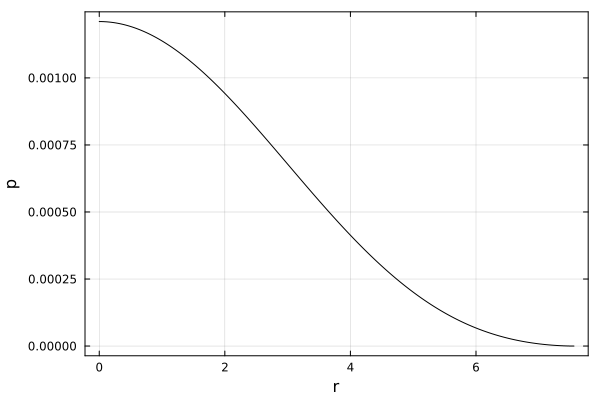

In [20]:
#Example plot of the pressure vs radial coordinates.
#Note quantities are in G=c=Mₛᵤₙ=1
plot(sol.t,sol[3,:],xlabel="r",ylabel="p",label="",framestyle=:box,color=:black)